## Gather the data

In [15]:
import numpy as np
import pickle
from simtk.openmm import unit
from openmmtools.constants import kB
import pandas as pd

import matplotlib.pyplot as plt
KT_KCALMOL = kB * 300 * unit.kelvin / unit.kilocalories_per_mole

In [16]:
def compute_ddg(apo_dg, complex_dg):
    return complex_dg * KT_KCALMOL - apo_dg * KT_KCALMOL

def compute_error(apo_ddg, complex_ddg):
    return (apo_ddg**2 + complex_ddg**2)**0.5 * KT_KCALMOL

In [17]:
# Retrieve free energies

main_dir = 47
replicate = 1
length = 10
sub_dirs = list(range(0, 4)) + list(range(5, 12)) + list(range(13, 17)) + list(range(18, 28))

d_results = {}
for sub_dir in sub_dirs:
    d_results[sub_dir] = {}
    for phase in ['apo', 'complex']:
        with open(f"/data/chodera/zhangi/perses_benchmark/repex/perses-bnbs-paper-fourth-attempt/{main_dir}/{sub_dir}/replicate_{replicate}/{phase}_free_energy_bootstrapped_{length}ns.pickle", "rb") as f:
            results = pickle.load(f)
            d_results[sub_dir][phase] = results

main_dir = 45
d_mapping = {4: 11, 12: 10, 17: 9}
for sub_dir in d_mapping.keys():
    d_results[sub_dir] = {}
    if sub_dir == 4:
        replicate = 0
    else:
        replicate = 1
    for phase in ['apo', 'complex']:
        with open(f"/data/chodera/zhangi/perses_benchmark/repex/perses-bnbs-paper-fourth-attempt/{main_dir}/{d_mapping[sub_dir]}/replicate_{replicate}/{phase}_free_energy_bootstrapped_{length}ns.pickle", "rb") as f:
            results = pickle.load(f)
            d_results[sub_dir][phase] = results


In [18]:
# Format the data appropriately for cinnabar

titles = ["Y29F", "Y29A",  "W38F", "T42A", "W44F", "E76A", "E80A", "D35A", "D39A", "K27A", "R59A", "R83Q", "R87A", "H102A", "F29Y", "A29Y",  "F38W", "A42T", "F44W", "A76E", "A80E", "A35D", "A39D", "A27K", "A59R", "Q83R", "A87R", "A102H"]

to_plot = []

for sub_dir in range(28):
    ddg = compute_ddg(d_results[sub_dir]['apo']["Deltaf"][0, -1], d_results[sub_dir]['complex']["Deltaf"][0, -1])
    dddg = compute_error(d_results[sub_dir]['apo']["dDeltaf"][0, -1], d_results[sub_dir]['complex']["dDeltaf"][0, -1])
    if sub_dir in range(14):
        to_plot.append([titles[sub_dir][:-1], titles[sub_dir][-1] + titles[sub_dir][1:-1], ddg, dddg*2, 0])
    else:
        to_plot.append(["-" + titles[sub_dir][:-1], "-" + titles[sub_dir][-1] + titles[sub_dir][1:-1], ddg * -1, dddg*2, 0])

        

In [19]:
to_plot

[['Y29', 'F29', 1.0614953535200264, 0.6698943974193585, 0],
 ['Y29', 'A29', 2.631145552280639, 0.760757261570947, 0],
 ['W38', 'F38', 0.40870070962636706, 0.6777088414962292, 0],
 ['T42', 'A42', 0.7808024898967787, 0.27478094367236605, 0],
 ['W44', 'F44', 0.10422351806408708, 0.8519971351004315, 0],
 ['E76', 'A76', 0.9600364875272691, 1.481207375275411, 0],
 ['E80', 'A80', 0.22575747080119513, 1.5491932600851857, 0],
 ['D35', 'A35', 1.6588340811494193, 1.0890173463806165, 0],
 ['D39', 'A39', 7.394021096666294, 1.2386649745825664, 0],
 ['K27', 'A27', 3.3190059071510234, 1.5164150835468635, 0],
 ['R59', 'A59', 3.3153633167397913, 1.7365219058753258, 0],
 ['R83', 'Q83', 4.988013317466471, 1.0903012756803006, 0],
 ['R87', 'A87', 11.40379760020781, 1.4650235895485961, 0],
 ['H102', 'A102', 8.754601826420796, 0.41313309617327887, 0],
 ['-F29', '-Y29', 0.7862032255668367, 0.8093590042665485, 0],
 ['-A29', '-Y29', 1.0571431914151113, 0.9761332151093736, 0],
 ['-F38', '-W38', 1.3573822869184209

In [20]:
# Get the discrepancy between forward and negative reverse DDGs

for i in range(14):
    print(to_plot[i][0:2], to_plot[i][2] - to_plot[i+14][2])

['Y29', 'F29'] 0.2752921279531897
['Y29', 'A29'] 1.5740023608655278
['W38', 'F38'] -0.9486815772920538
['T42', 'A42'] 1.7955469625076397
['W44', 'F44'] 0.1417290106305482
['E76', 'A76'] -0.806094519529786
['E80', 'A80'] -0.24812502604243392
['D35', 'A35'] -0.4751306194305043
['D39', 'A39'] 1.018173864145198
['K27', 'A27'] -0.6347394592216773
['R59', 'A59'] -1.3172322718496332
['R83', 'Q83'] 8.743891503659189
['R87', 'A87'] 6.5952212624212905
['H102', 'A102'] 1.0937335744790317


In [21]:
# Get the discrepancy between forward and negative reverse DDGs (including 95% CI error bars)

labels_internal_consistency = []
for i in range(14):
    discrepancy = round(to_plot[i][2] - to_plot[i+14][2], 2)
    forward_ddg = round(to_plot[i][2], 2)
    reverse_ddg = round(to_plot[i+14][2], 2)
    forward_ci = [round(to_plot[i][2] - to_plot[i][3], 2), round(to_plot[i][2] + to_plot[i][3])]
    reverse_ci = [round(to_plot[i+14][2] - to_plot[i+14][3], 2), round(to_plot[i+14][2] + to_plot[i+14][3])]
    forward_ci_extended = [forward_ci[0] - 1, forward_ci[1] + 1]
    reverse_ci_extended = [reverse_ci[0] - 1, reverse_ci[1] + 1]
    is_within_error = (forward_ci_extended[0] <= reverse_ddg and reverse_ddg <= forward_ci_extended[1]) or (reverse_ci_extended[0] <= forward_ddg and forward_ddg <= reverse_ci_extended[1])
    print(to_plot[i][0:2], discrepancy, forward_ddg, forward_ci, reverse_ddg, reverse_ci, is_within_error)
    if not is_within_error:
        labels_internal_consistency.append(titles[i])
    else:
        labels_internal_consistency.append("")
    

['Y29', 'F29'] 0.28 1.06 [0.39, 2] 0.79 [-0.02, 2] True
['Y29', 'A29'] 1.57 2.63 [1.87, 3] 1.06 [0.08, 2] True
['W38', 'F38'] -0.95 0.41 [-0.27, 1] 1.36 [0.61, 2] True
['T42', 'A42'] 1.8 0.78 [0.51, 1] -1.01 [-1.34, -1] False
['W44', 'F44'] 0.14 0.1 [-0.75, 1] -0.04 [-0.93, 1] True
['E76', 'A76'] -0.81 0.96 [-0.52, 2] 1.77 [-0.12, 4] True
['E80', 'A80'] -0.25 0.23 [-1.32, 2] 0.47 [-1.26, 2] True
['D35', 'A35'] -0.48 1.66 [0.57, 3] 2.13 [0.86, 3] True
['D39', 'A39'] 1.02 7.39 [6.16, 9] 6.38 [4.93, 8] True
['K27', 'A27'] -0.63 3.32 [1.8, 5] 3.95 [2.67, 5] True
['R59', 'A59'] -1.32 3.32 [1.58, 5] 4.63 [3.06, 6] True
['R83', 'Q83'] 8.74 4.99 [3.9, 6] -3.76 [-5.21, -2] False
['R87', 'A87'] 6.6 11.4 [9.94, 13] 4.81 [3.59, 6] False
['H102', 'A102'] 1.09 8.75 [8.34, 9] 7.66 [7.25, 8] True


In [22]:
# Get the discrepancy from experiment

experiment = [-0.1, 3.4, 1.6, 1.8, 0, 1.4, 0.5, 4.5, 7.7, 5.4, 5.2, 5.4, 5.5, 6.1, -0.1, 3.4, 1.6, 1.8, 0, 1.4, 0.5, 4.5, 7.7, 5.4, 5.2, 5.4, 5.5, 6.1]
for i in range(28):
    print(to_plot[i][0:2], to_plot[i][2] - experiment[i])
    

['Y29', 'F29'] 1.1614953535200265
['Y29', 'A29'] -0.7688544477193608
['W38', 'F38'] -1.191299290373633
['T42', 'A42'] -1.0191975101032213
['W44', 'F44'] 0.10422351806408708
['E76', 'A76'] -0.4399635124727308
['E80', 'A80'] -0.2742425291988049
['D35', 'A35'] -2.8411659188505807
['D39', 'A39'] -0.30597890333370614
['K27', 'A27'] -2.080994092848977
['R59', 'A59'] -1.8846366832602088
['R83', 'Q83'] -0.411986682533529
['R87', 'A87'] 5.90379760020781
['H102', 'A102'] 2.6546018264207962
['-F29', '-Y29'] 0.8862032255668367
['-A29', '-Y29'] -2.3428568085848887
['-F38', '-W38'] -0.2426177130815792
['-A42', '-T42'] -2.814744472610861
['-F44', '-W44'] -0.03750549256646113
['-A76', '-E76'] 0.36613100705705515
['-A80', '-E80'] -0.026117503156370958
['-A35', '-D35'] -2.3660352994200764
['-A39', '-D39'] -1.3241527674789042
['-A27', '-K27'] -1.4462546336272997
['-A59', '-R59'] -0.5674044114105756
['-Q83', '-R83'] -9.155878186192718
['-A87', '-R87'] -0.6914236622134808
['-A102', '-H102'] 1.5608682519417

In [23]:
# Get the discrepancy from experiment (including 95% CI error bars for predicted and experiment)

labels_accuracy = []
experiment = [-0.1, 3.4, 1.6, 1.8, 0, 1.4, 0.5, 4.5, 7.7, 5.4, 5.2, 5.4, 5.5, 6.1, -0.1, 3.4, 1.6, 1.8, 0, 1.4, 0.5, 4.5, 7.7, 5.4, 5.2, 5.4, 5.5, 6.1]
for i in range(28):
    discrepancy = round(to_plot[i][2] - experiment[i], 2)
    predicted_ci = [round(to_plot[i][2] - to_plot[i][3], 2), round(to_plot[i][2] + to_plot[i][3], 2)]
    predicted_ci_extended = [predicted_ci[0] - 1, predicted_ci[1] + 1]
    is_within_error = experiment[i] + 0.2 > predicted_ci_extended[0] and experiment[i] - 0.2 < predicted_ci_extended[1]
    print(to_plot[i][0:2], discrepancy, experiment[i], predicted_ci_extended, is_within_error)
    if not is_within_error:
        if i >= 14:
            labels_accuracy.append(f"-({titles[i]})")
        else:
            labels_accuracy.append(titles[i])
    else:
        labels_accuracy.append("")
    

['Y29', 'F29'] 1.16 -0.1 [-0.61, 2.73] True
['Y29', 'A29'] -0.77 3.4 [0.8700000000000001, 4.390000000000001] True
['W38', 'F38'] -1.19 1.6 [-1.27, 2.09] True
['T42', 'A42'] -1.02 1.8 [-0.49, 2.06] True
['W44', 'F44'] 0.1 0 [-1.75, 1.96] True
['E76', 'A76'] -0.44 1.4 [-1.52, 3.44] True
['E80', 'A80'] -0.27 0.5 [-2.3200000000000003, 2.77] True
['D35', 'A35'] -2.84 4.5 [-0.43000000000000005, 3.75] False
['D39', 'A39'] -0.31 7.7 [5.16, 9.63] True
['K27', 'A27'] -2.08 5.4 [0.8, 5.84] True
['R59', 'A59'] -1.88 5.2 [0.5800000000000001, 6.05] True
['R83', 'Q83'] -0.41 5.4 [2.9, 7.08] True
['R87', 'A87'] 5.9 5.5 [8.94, 13.87] False
['H102', 'A102'] 2.65 6.1 [7.34, 10.17] False
['-F29', '-Y29'] 0.89 -0.1 [-1.02, 2.6] True
['-A29', '-Y29'] -2.34 3.4 [-0.92, 3.03] False
['-F38', '-W38'] -0.24 1.6 [-0.39, 3.11] True
['-A42', '-T42'] -2.81 1.8 [-2.34, 0.31000000000000005] False
['-F44', '-W44'] -0.04 0 [-1.9300000000000002, 1.85] True
['-A76', '-E76'] 0.37 1.4 [-1.12, 4.65] True
['-A80', '-E80'] -0.

In [24]:
# Assemble experimental values

d = {'WT': 19.0, 'A27': 13.6, 'A59': 13.8, 'Q83': 13.6, 'A87': 13.5, 
     'A35': 14.5, 'A39': 11.3, 'A76': 17.65, 'A80': 18.5, 'F29': 19.1, 
     'A29': 15.6, 'F38': 17.4, 'A42': 17.2, 'F44': 19.0, 'A102': 12.9,
     
    '-A27': -13.6, '-A59': -13.8, '-Q83': -13.6, '-A87': -13.5, 
     '-A35': -14.5, '-A39': -11.3, '-A76': -17.65, '-A80': -18.5, '-F29': -19.1, 
     '-A29': -15.6, '-F38': -17.4, '-A42': -17.2, '-F44': -19.0, '-A102': -12.9
    }

experiment = []
for k in d.keys():
    if k == 'WT':
        for wt_residue in ['K27', 'R59', 'R83', 'R87', 'H102', 
                           'D35', 'D39', 'E76', 'E80',
                           'Y29', 'W38', 'T42', 'W44']:
            experiment.append([wt_residue, d[k]*-1, 0.1*2]) 
            experiment.append(["-" + wt_residue, d[k], 0.1*2])
    else:
        experiment.append([k, d[k]*-1, 0.1*2]) 
        
# Note: we take the negative of everything because the free energies are subtracted differently in Schreiber et al

## Calculated vs Experiment plot

In [11]:
import numpy as np

%matplotlib inline
import matplotlib.pylab as plt

from cinnabar import plotting, stats, wrangle

In [30]:
# Write csv with data
pd.DataFrame(experiment + to_plot).to_csv(f"/data/chodera/zhangi/perses_benchmark/repex/perses-bnbs-paper-fourth-attempt/cinnabar_input_10ns.csv", index=False, header=False)
# Had to manually add headings, otherwise the lists wouldn't print out as comma separated
# Had to remove extra commas in experimental block


In [12]:
# Create map with the csv file
fe = wrangle.FEMap('/data/chodera/zhangi/perses_benchmark/repex/perses-bnbs-paper-fourth-attempt/cinnabar_input_10ns.csv')


Graph is not connected enough to compute absolute values


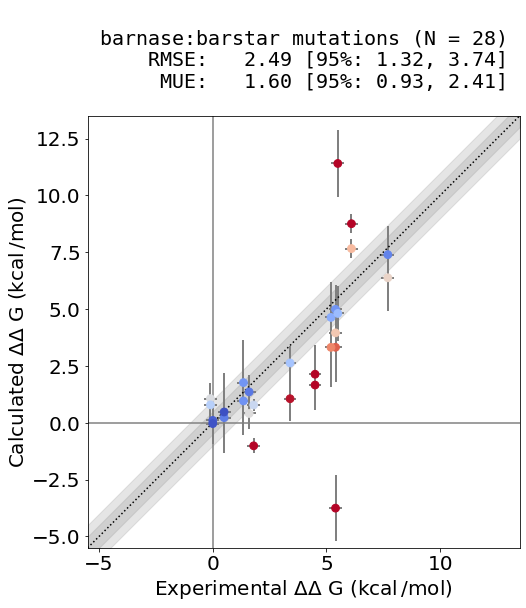

In [13]:
# Format data appropriately
x = [edge[2]["exp_DDG"] for edge in fe.graph.edges(data=True)]
y = [edge[2]["calc_DDG"] for edge in fe.graph.edges(data=True)]
xerr = np.asarray([edge[2]["exp_dDDG"] for edge in fe.graph.edges(data=True)])
yerr = np.asarray([edge[2]["calc_dDDG"] for edge in fe.graph.edges(data=True)])
x_data = np.asarray(x)
y_data = np.asarray(y)

# Generate the plot
filename = '/data/chodera/zhangi/perses_benchmark/repex/perses-bnbs-paper-fourth-attempt/cinnabar_plot_10ns.pdf'
plot = plotting._master_plot(
    x_data,
    y_data,
    xerr=xerr,
    yerr=yerr,
    filename=filename,
    title="",
    target_name="barnase:barstar mutations",
    units=r'$\mathrm{kcal\,/mol}$', 
    figsize=10, 
    dpi=500,
    xy_lim=[-5.5, 13.5],
#    data_labels=labels_accuracy,
    font_sizes={"title":20, "labels": 20, "other": 20},
    scatter_kwargs={'s': 60}
)

## -Reverse vs Forward plot

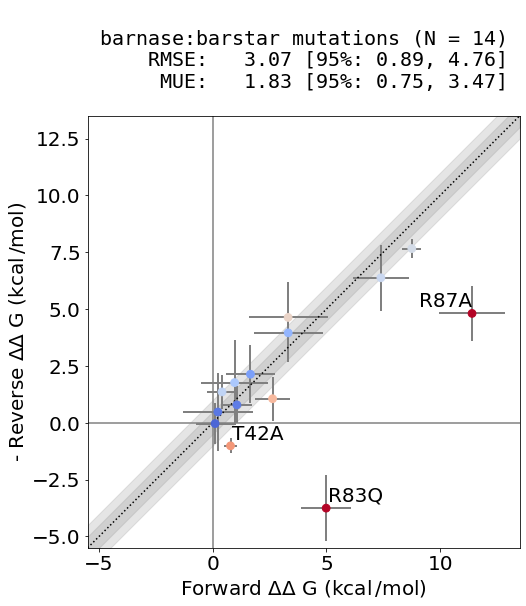

In [14]:
# Format the data appropriately
x = [entry[2] for i, entry in enumerate(to_plot) if i < 14] # forward
y = [entry[2] for i, entry in enumerate(to_plot) if i >= 14] # reverse
xerr =  [entry[3] for i, entry in enumerate(to_plot) if i < 14] # forward
yerr = [entry[3] for i, entry in enumerate(to_plot) if i >= 14] # reverse
x_data = np.asarray(x)
y_data = np.asarray(y)

# Generate the plot
filename = '/data/chodera/zhangi/perses_benchmark/repex/perses-bnbs-paper-fourth-attempt/cinnabar_plot_10ns_internal_consistency.pdf'
plot = plotting._master_plot(
    x_data,
    y_data,
    xerr=xerr,
    yerr=yerr,
    filename=filename,
    title="",
    target_name="barnase:barstar mutations",
    xlabel="Forward",
    ylabel="- Reverse",
    units=r'$\mathrm{kcal\,/mol}$', 
    figsize=10, 
    dpi=500,
    xy_lim=[-5.5, 13.5],
    data_labels=labels_internal_consistency,
    font_sizes={"title":20, "labels": 20, "other": 20},
    scatter_kwargs={'s': 60}
)


## Table

In [39]:
# Format the data appropriately for table

titles = ["Y29F", "Y29A",  "W38F", "T42A", "W44F", "E76A", "E80A", "D35A", "D39A", "K27A", "R59A", "R83Q", "R87A", "H102A", "F29Y", "A29Y",  "F38W", "A42T", "F44W", "A76E", "A80E", "A35D", "A39D", "A27K", "A59R", "Q83R", "A87R", "A102H"]
experiment = [-0.1, 3.4, 1.6, 1.8, 0, 1.4, 0.5, 4.5, 7.7, 5.4, 5.2, 5.4, 5.5, 6.1, 0.1, -3.4, -1.6, -1.8, 0, -1.4, -0.5, -4.5, -7.7, -5.4, -5.2, -5.4, -5.5, -6.1]

to_plot = []

for sub_dir in range(28):
    ddg = compute_ddg(d_results[sub_dir]['apo']["Deltaf"][0, -1], d_results[sub_dir]['complex']["Deltaf"][0, -1])
    dddg = compute_error(d_results[sub_dir]['apo']["dDeltaf"][0, -1], d_results[sub_dir]['complex']["dDeltaf"][0, -1])
    if sub_dir in range(14):
        to_plot.append([titles[sub_dir], round(ddg, 2), round(dddg, 2), experiment[sub_dir], 10, 10, "forward"])
    else:
        to_plot.append([titles[sub_dir], round(ddg, 2), round(dddg, 2), experiment[sub_dir], 10, 10, "reverse"])


In [40]:
df = pd.DataFrame(to_plot, columns=["Mutation", r"Predicted $\Delta\Delta$G (kcal/mol)", "Error (kcal/mol)", "Experimental $\Delta\Delta$G (kcal/mol)", "Complex phase simulation time (ns/replica)", "Apo phase simulation time (ns/replica)", "Mutation direction"])

In [41]:
df

,Mutation,Predicted $\Delta\Delta$G (kcal/mol),Error (kcal/mol),Experimental $\Delta\Delta$G (kcal/mol),Complex phase simulation time (ns/replica),Apo phase simulation time (ns/replica),Mutation direction
0,Y29F,1.06,0.33,-0.1,10,10,forward
1,Y29A,2.63,0.38,3.4,10,10,forward
2,W38F,0.41,0.34,1.6,10,10,forward
3,T42A,0.78,0.14,1.8,10,10,forward
4,W44F,0.10,0.43,0.0,10,10,forward
5,E76A,0.96,0.74,1.4,10,10,forward
6,E80A,0.23,0.77,0.5,10,10,forward
7,D35A,1.66,0.54,4.5,10,10,forward
8,D39A,7.39,0.62,7.7,10,10,forward
9,K27A,3.32,0.76,5.4,10,10,forward


In [42]:
df.to_csv("/data/chodera/zhangi/perses_benchmark/repex/perses-bnbs-paper-fourth-attempt/table_10ns_arex.csv", index=False)